In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install -qqq pydotplus
!pip install imbalanced-learn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O| (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from collections import Counter


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noshowappointments/KaggleV2-May-2016.csv


In [2]:
def get_dummies_encoder(df, cols):
    return pd.get_dummies(df, columns=cols)

def sklearn_encoder(df, cols):
    encoder = OneHotEncoder(sparse=False)

    one_hot_encoded_dfs = []

    for col_name in cols:
        col_reshaped = df[col_name].values.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(col_reshaped)

        one_hot_encoded_df = pd.DataFrame(
            one_hot_encoded,
            columns=encoder.get_feature_names_out([col_name]),
            index=df.index,
        )

        one_hot_encoded_dfs.append(one_hot_encoded_df)

    df_encoded = pd.concat([df] + one_hot_encoded_dfs, axis=1)
    df_encoded.drop(cols, axis=1, inplace=True)

    return df_encoded

In [3]:
def get_metrics(y_pred, y_test):
    value_counts = Counter(y_pred)

    print("Count of unique values in y_pred:")
    for value, count in value_counts.items():
        print(f"{value}: {count}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print("confusion matrix")
    print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}\n")
    
    report = classification_report(y_test, y_pred, output_dict=True)
    # Format and print the classification report
    print("Classification Report:")
    print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("Class", "Precision", "Recall", "F1-Score", "Support"))
    for class_label, metrics in report.items():
        if class_label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        print("{:<15} {:<15.2f} {:<15.2f} {:<15.2f} {:<15}".format(class_label, 
                                                                    metrics['precision'], 
                                                                    metrics['recall'], 
                                                                    metrics['f1-score'], 
                                                                    metrics['support']))
    print("\n\n")

In [4]:
def fit_and_predict(df, model, model_name):
    X = df.drop('No-show', axis=1)
    y = df['No-show']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print(model_name, "METRICS")
    get_metrics(y_pred, y_test)

In [5]:
def grid_search_classification(df):

    X = df.drop('No-show', axis=1)
    y = df['No-show']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


    # Define hyperparameters grid

    models = [
        {
            "name": "Random Forest",
            "model": RandomForestClassifier(),
            "params": {
                "n_estimators": [50, 100, 150],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
            },
        },
        {
            "name": "Logistic Reg",
            "model": LogisticRegression(),
            "params": {
                "solver": ["newton-cg", "lbfgs", "liblinear"],
                "penalty": ["l2"],
                "C": [100, 10, 1.0, 0.1, 0.01],
            },
        },
        {
            "name": "Gaussian NB",
            "model": GaussianNB(),
            "params":{'var_smoothing': [1e-11, 1e-10, 1e-9]},
        },
        {
            "name": "Decision Tree",
            "model": DecisionTreeClassifier(),
            "params":{
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
    ]


    for model in models:
        print(model["name"], "Grid Search Running")

        grid_search = GridSearchCV(estimator=model["model"], param_grid=model["params"], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        print("Best Parameters:", grid_search.best_params_)
        best_rf_classifier = grid_search.best_estimator_
        y_pred = best_rf_classifier.predict(X_test)

        get_metrics(y_pred, y_test)

In [6]:
def get_class_distribution(df, col):
    
    # Count occurrences of each class
    class_distribution = df[col].value_counts()

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    class_distribution.plot(kind='bar', color=['blue', 'red'])
    plt.title('Class Distribution of No-show')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Show', 'No-show'], rotation=0)
    plt.show()

    # Print class distribution counts
    print("Class Distribution:")
    print(class_distribution)

    print(class_distribution[1]/class_distribution[0])

In [7]:
df=pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')

In [8]:
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [9]:
duplicate_rows = df[df.duplicated()]

# Checking how many duplicates are there
num_duplicates = len(duplicate_rows)
print("Number of duplicate rows:", num_duplicates)

# If you want to see the duplicated rows
print("Duplicated rows:")
duplicate_rows

Number of duplicate rows: 0
Duplicated rows:


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [10]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

df['Difference'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

In [11]:
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Difference
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,2016-06-07 00:00:00+00:00,56,MARIA ORTIZ,0,0,0,0,0,1,No,34
110523,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,No,34
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,2016-06-07 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,1,No,40
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23+00:00,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,No,40


In [12]:
df = df[df['Difference'] >= 0]

In [13]:
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Difference
5,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1
6,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1
7,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1
9,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1
10,7.345362e+14,5630213,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,2016-06-07 00:00:00+00:00,56,MARIA ORTIZ,0,0,0,0,0,1,No,34
110523,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,No,34
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,2016-06-07 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,1,No,40
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23+00:00,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,No,40


In [14]:
# df.drop(index=99832, inplace=True)

df.drop(['AppointmentID','PatientId','ScheduledDay','AppointmentDay'],inplace=True,axis=1)
df.drop(['Neighbourhood'],inplace=True,axis=1)

df.rename(columns={'Hipertension':'Hypertension'},inplace=True)

df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})

cols_to_encode = ["Scholarship", "Hypertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "Gender"]

df = get_dummies_encoder(df, cols_to_encode)

/tmp/ipykernel_18/938893851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['AppointmentID','PatientId','ScheduledDay','AppointmentDay'],inplace=True,axis=1)
/tmp/ipykernel_18/938893851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Neighbourhood'],inplace=True,axis=1)
/tmp/ipykernel_18/938893851.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Hipertension':'Hypertension'},inplace=Tru

In [15]:
duplicate_rows = df[df.duplicated()]

# Checking how many duplicates are there
num_duplicates = len(duplicate_rows)
print("Number of duplicate rows:", num_duplicates)

# If you want to see the duplicated rows
print("Duplicated rows:")
duplicate_rows

Number of duplicate rows: 38420
Duplicated rows:


,Age,No-show,Difference,Scholarship_0,Scholarship_1,Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,Alcoholism_0,Alcoholism_1,Handcap_0,Handcap_1,Handcap_2,Handcap_3,Handcap_4,SMS_received_0,SMS_received_1,Gender_F,Gender_M
52,23,1,28,False,True,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False
65,0,0,1,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True
110,34,0,16,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False
154,30,0,0,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False
210,47,0,2,True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,56,0,34,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False
110523,51,0,34,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False
110524,21,0,40,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False
110525,38,0,40,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,True,False


In [16]:
df.duplicated()

5         False
6         False
7         False
9         False
10        False
          ...  
110522     True
110523     True
110524     True
110525     True
110526     True
Length: 71959, dtype: bool

In [17]:
df = df.drop_duplicates()

In [18]:
df.duplicated().sum()

0

In [19]:
duplicate_rows = df[df.duplicated()]

# Checking how many duplicates are there
num_duplicates = len(duplicate_rows)
print("Number of duplicate rows:", num_duplicates)

# If you want to see the duplicated rows
print("Duplicated rows:")
duplicate_rows

Number of duplicate rows: 0
Duplicated rows:


,Age,No-show,Difference,Scholarship_0,Scholarship_1,Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,Alcoholism_0,Alcoholism_1,Handcap_0,Handcap_1,Handcap_2,Handcap_3,Handcap_4,SMS_received_0,SMS_received_1,Gender_F,Gender_M


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33539 entries, 5 to 110515
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             33539 non-null  int64
 1   No-show         33539 non-null  int64
 2   Difference      33539 non-null  int64
 3   Scholarship_0   33539 non-null  bool 
 4   Scholarship_1   33539 non-null  bool 
 5   Hypertension_0  33539 non-null  bool 
 6   Hypertension_1  33539 non-null  bool 
 7   Diabetes_0      33539 non-null  bool 
 8   Diabetes_1      33539 non-null  bool 
 9   Alcoholism_0    33539 non-null  bool 
 10  Alcoholism_1    33539 non-null  bool 
 11  Handcap_0       33539 non-null  bool 
 12  Handcap_1       33539 non-null  bool 
 13  Handcap_2       33539 non-null  bool 
 14  Handcap_3       33539 non-null  bool 
 15  Handcap_4       33539 non-null  bool 
 16  SMS_received_0  33539 non-null  bool 
 17  SMS_received_1  33539 non-null  bool 
 18  Gender_F        33539 non-null

In [21]:
df.describe()

,Age,No-show,Difference
count,33539.000000,33539.000000,33539.000000
mean,42.545872,0.365276,20.440890
std,23.166369,0.481515,19.526146
min,0.000000,0.000000,0.000000
25%,24.000000,0.000000,6.000000
50%,44.000000,0.000000,15.000000
75%,60.000000,1.000000,29.000000
max,115.000000,1.000000,178.000000


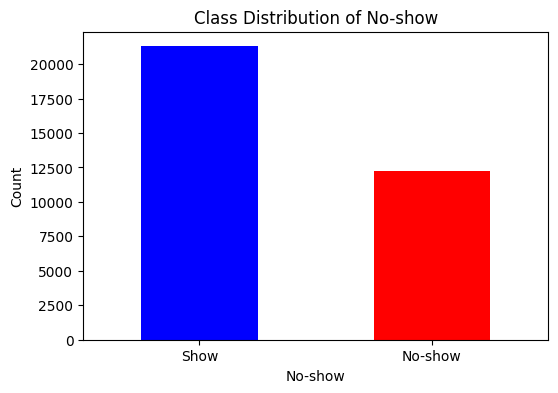

Class Distribution:
No-show
0    21288
1    12251
Name: count, dtype: int64
0.575488538143555


In [22]:
get_class_distribution(df, 'No-show')

In [23]:
# scaler = MinMaxScaler()

# age_column = df['Age'].values.reshape(-1, 1)
# normalized_age = scaler.fit_transform(age_column)
# df['Age'] = normalized_age

# diff_col = df["Difference"].values.reshape(-1, 1)
# normalized_diff = scaler.fit_transform(diff_col)
# df["Difference"] = normalized_diff

In [24]:
bins=[0, 10, 18, 30, 60, 80, 100]
group_name = ['child', 'teens', 'young', 'middle_age', 'old','very_old']

In [25]:
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=group_name, right=False)

In [26]:
df.drop("Age", axis=1, inplace=True)

In [27]:
cols_to_encode = ["age_group"]

df = get_dummies_encoder(df, cols_to_encode)

In [28]:
df

,No-show,Difference,Scholarship_0,Scholarship_1,Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,Alcoholism_0,Alcoholism_1,...,SMS_received_0,SMS_received_1,Gender_F,Gender_M,age_group_child,age_group_teens,age_group_young,age_group_middle_age,age_group_old,age_group_very_old
5,0,1,True,False,False,True,True,False,True,False,...,True,False,True,False,False,False,False,False,True,False
6,1,1,True,False,True,False,True,False,True,False,...,True,False,True,False,False,False,True,False,False,False
7,1,1,True,False,True,False,True,False,True,False,...,True,False,True,False,False,False,False,True,False,False
9,0,1,True,False,True,False,True,False,True,False,...,True,False,True,False,False,False,True,False,False,False
10,0,1,True,False,True,False,True,False,True,False,...,True,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110479,1,37,False,True,True,False,True,False,True,False,...,False,True,True,False,False,False,False,True,False,False
110480,0,46,True,False,True,False,True,False,True,False,...,False,True,True,False,False,False,False,True,False,False
110482,1,37,False,True,True,False,True,False,True,False,...,False,True,True,False,False,False,False,True,False,False
110496,1,1,True,False,False,True,True,False,True,False,...,True,False,True,False,False,False,False,True,False,False


In [29]:
unique_values_with_counts = df['Difference'].value_counts()

print(unique_values_with_counts)

df.describe()

Difference
3      1689
6      1434
5      1406
4      1327
1      1269
       ... 
81        1
126       1
125       1
150       1
122       1
Name: count, Length: 128, dtype: int64


,No-show,Difference
count,33539.000000,33539.000000
mean,0.365276,20.440890
std,0.481515,19.526146
min,0.000000,0.000000
25%,0.000000,6.000000
50%,0.000000,15.000000
75%,1.000000,29.000000
max,1.000000,178.000000


In [30]:
missing_values = df.isna().sum()
missing_values

No-show                 0
Difference              0
Scholarship_0           0
Scholarship_1           0
Hypertension_0          0
Hypertension_1          0
Diabetes_0              0
Diabetes_1              0
Alcoholism_0            0
Alcoholism_1            0
Handcap_0               0
Handcap_1               0
Handcap_2               0
Handcap_3               0
Handcap_4               0
SMS_received_0          0
SMS_received_1          0
Gender_F                0
Gender_M                0
age_group_child         0
age_group_teens         0
age_group_young         0
age_group_middle_age    0
age_group_old           0
age_group_very_old      0
dtype: int64

Class Distribution after SMOTE:
No-show
0    21288
1    12772
Name: count, dtype: int64


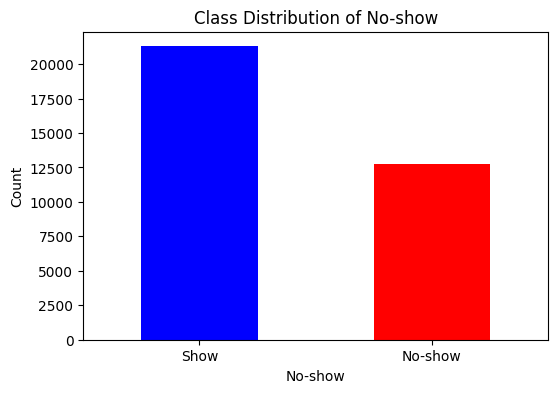

Class Distribution:
No-show
0    21288
1    12772
Name: count, dtype: int64
0.5999624201428034


In [31]:
from imblearn.over_sampling import SMOTE

# Assuming your DataFrame is named df and target variable is 'No-show'

# Separate features and target variable
X = df.drop('No-show', axis=1)
y = df['No-show']

# Instantiate SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=42)

# Apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled data back to DataFrame if necessary
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='No-show')], axis=1)

# Check class distribution after resampling
print("Class Distribution after SMOTE:")
print(df_resampled['No-show'].value_counts())

get_class_distribution(df_resampled, 'No-show')

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models = [
    {
        "name": "Random Forest",
        "model": RandomForestClassifier(),
    },
    {
        "name": "Decision Tree",
        "model": DecisionTreeClassifier(),
    },
    {
        "name": "Logistic Regression",
        "model": LogisticRegression(),
    },
    {
        "name": "Gaussian Naive Bayes",
        "model": GaussianNB(),
    },
]

# models = [RandomForestClassifier(), DecisionTreeClassifier(), LogisticRegression(), GaussianNB()]


for model in models:
    fit_and_predict(df_resampled, model["model"], model["name"])

Random Forest METRICS
Count of unique values in y_pred:
0: 7790
1: 2428
confusion matrix
tn: 4798, fp: 1606, fn: 2992, tp: 822

Classification Report:
Class           Precision       Recall          F1-Score        Support        
0               0.62            0.75            0.68            6404           
1               0.34            0.22            0.26            3814           



Decision Tree METRICS
Count of unique values in y_pred:
0: 8358
1: 1860
confusion matrix
tn: 5187, fp: 1224, fn: 3171, tp: 636

Classification Report:
Class           Precision       Recall          F1-Score        Support        
0               0.62            0.81            0.70            6411           
1               0.34            0.17            0.22            3807           



Logistic Regression METRICS
Count of unique values in y_pred:
0: 10139
1: 79
confusion matrix
tn: 6345, fp: 38, fn: 3794, tp: 41

Classification Report:
Class           Precision       Recall          F1-Score   

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
from sklearn.ensemble import AdaBoostClassifier

def boosting_classification(df):
    params = {'var_smoothing': 1e-09}
    
    X = df.drop('No-show', axis=1)
    y = df['No-show']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = AdaBoostClassifier(GaussianNB(**params), random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print("Ada Classification", "METRICS")
    get_metrics(y_pred, y_test)

In [34]:
from sklearn.ensemble import VotingClassifier

def voting_classifier(df):
    X = df.drop('No-show', axis=1)
    y = df['No-show']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = VotingClassifier(
        estimators=[("logistic reg", LogisticRegression()), ("random forest", RandomForestClassifier()), ("gaussian nb", GaussianNB())],
        voting= "hard",
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print("Voting Classification", "METRICS")
    get_metrics(y_pred, y_test)

In [35]:
voting_classifier(df_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classification METRICS
Count of unique values in y_pred:
0: 9921
1: 297
confusion matrix
tn: 6211, fp: 192, fn: 3710, tp: 105

Classification Report:
Class           Precision       Recall          F1-Score        Support        
0               0.63            0.97            0.76            6403           
1               0.35            0.03            0.05            3815           





In [36]:
from sklearn.ensemble import BaggingClassifier

def bagging_classification(df):
    X = df.drop('No-show', axis=1)
    y = df['No-show']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500, max_samples=100, bootstrap=True, oob_score=True)
    
    model.fit(X_train, y_train)
    
    print("oob score", model.oob_score_)
    
    y_pred = model.predict(X_test)
    
    print("Bagging Classification", "METRICS")
    get_metrics(y_pred, y_test)
    
    

In [37]:
bagging_classification(df_resampled)

oob score 0.6227665464306685
Bagging Classification METRICS
Count of unique values in y_pred:
0: 10010
1: 208
confusion matrix
tn: 6266, fp: 112, fn: 3744, tp: 96

Classification Report:
Class           Precision       Recall          F1-Score        Support        
0               0.63            0.98            0.76            6378           
1               0.46            0.03            0.05            3840           



